# The idea

I have an idea for my variability spreadsheet code (an idea that may be more eloquent and panda-onic (like pythonic?) than my NamedTuples approach): using the approach advocated [here](https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns/47103408).

I'm curious whether I can make it work.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(np.random.rand(4,4), columns=list('abcd'))
df['group'] = [0, 0, 1, 1]
df

,a,b,c,d,group
0,0.584785,0.277746,0.144040,0.092823,0
1,0.044362,0.983116,0.981404,0.694826,0
2,0.424571,0.645111,0.684573,0.780175,1
3,0.407273,0.700947,0.725432,0.636241,1


In [2]:
df.groupby('group').agg({'a':['sum', 'max'], 
                         'b':'mean', 
                         'c':'sum', 
                         'd': lambda x: x.max() - x.min()})

a                   b         c         d
            sum       max      mean       sum  <lambda>
group                                                  
0      0.629147  0.584785  0.630431  1.125444  0.602002
1      0.831844  0.424571  0.673029  1.410005  0.143934

In [3]:
def max_min(x):
    return x.max() - x.min()

max_min.__name__ = 'Max minus Min'

df.groupby('group').agg({'a':['sum', 'max'], 
                         'b':'mean', 
                         'c':'sum', 
                         'd': max_min})

a                   b         c             d
            sum       max      mean       sum Max minus Min
group                                                      
0      0.629147  0.584785  0.630431  1.125444      0.602002
1      0.831844  0.424571  0.673029  1.410005      0.143934

In [4]:
def f(x):
    d = {}
    d['a_sum'] = x['a'].sum()
    d['a_max'] = x['a'].max()
    d['b_mean'] = x['b'].mean()
    d['c_d_prodsum'] = (x['c'] * x['d']).sum()
    return pd.Series(d, index=['a_sum', 'a_max', 'b_mean', 'c_d_prodsum'])

df.groupby('group').apply(f)

,a_sum,a_max,b_mean,c_d_prodsum
group,,,,
0,0.629147,0.584785,0.630431,0.695275
1,0.831844,0.424571,0.673029,0.995636


In [5]:
def f_mi(x):
    d = []
    d.append(x['a'].sum())
    d.append(x['a'].max())
    d.append(x['b'].mean())
    d.append((x['c'] * x['d']).sum())
    return pd.Series(d, index=[['a', 'a', 'b', 'c_d'], 
                               ['sum', 'max', 'mean', 'prodsum']])

multi_groupby = df.groupby('group').apply(f_mi)
multi_groupby

a                   b       c_d
            sum       max      mean   prodsum
group                                        
0      0.629147  0.584785  0.630431  0.695275
1      0.831844  0.424571  0.673029  0.995636

In [6]:
multi_groupby['a']['max']

group
0    0.584785
1    0.424571
Name: max, dtype: float64

okay, so what if we had like... 3 types of variables (J, H, K), and we wanted to do mean, median, min, max, range, ... let's try it with mean/median/std for J and H following the syntax they've got:

In [7]:
from astropy.table import Table

dat = Table.read('/Users/tsrice/Desktop/Academia/Variability_Data_2019/WSERV8_results6_23_50_28_30335.fits', format='fits')

sentinel_value = -999999488.0
for column in dat.columns:
    if (dat[column].dtype == '>f8') or (dat[column].dtype == '>f4'):
        nulls = [dat[column] == sentinel_value]
        print(f"column {column} has {np.sum(nulls)} nulls")
        dat[column][dat[column] == sentinel_value] = np.nan

dat['JAPERMAG3ERR'] = (1.082 * dat['JAPERMAG3ERR']**2 + 0.021**2)**0.5
dat['HAPERMAG3ERR'] = (1.082 * dat['HAPERMAG3ERR']**2 + 0.021**2)**0.5
dat['KAPERMAG3ERR'] = (1.082 * dat['KAPERMAG3ERR']**2 + 0.021**2)**0.5


# dat_subset = dat[(
#     (dat['JAPERMAG3'] < 15) & (dat['JAPERMAG3'] > 12) &
#     (dat['HAPERMAG3'] < 15) & (dat['HAPERMAG3'] > 12) &
#     (dat['KAPERMAG3'] < 15) & (dat['KAPERMAG3'] > 12))]

df = dat.to_pandas()


column MEANMJDOBS has 0 nulls
column RA has 0 nulls
column DEC has 0 nulls
column JMHPNT has 612740 nulls
column JMHPNTERR has 612740 nulls
column HMKPNT has 435914 nulls
column HMKPNTERR has 435914 nulls
column JAPERMAG3 has 541266 nulls
column HAPERMAG3 has 276269 nulls
column KAPERMAG3 has 212267 nulls
column PSTAR has 0 nulls


In [8]:
# just a quick test of this, 
df.groupby('SOURCEID').apply(np.mean)

,SOURCEID,MEANMJDOBS,RA,DEC,JMHPNT,JMHPNTERR,HMKPNT,HMKPNTERR,JAPERMAG3,JAPERMAG3ERR,HAPERMAG3,HAPERMAG3ERR,KAPERMAG3,KAPERMAG3ERR,JPPERRBITS,HPPERRBITS,KPPERRBITS,MERGEDCLASS,PSTAR
SOURCEID,,,,,,,,,,,,,,,,,,,
44989782425636,4.498978e+13,56996.757397,0.980061,0.557602,1.166593,0.177377,0.582503,0.135496,19.189305,2.647761e+08,18.024357,8.825869e+07,17.440517,5.673773e+07,36938.472727,14100.266667,89963.054545,0.333333,0.238551
44989782425657,4.498978e+13,56995.009049,0.980041,0.556831,0.868558,0.040707,0.425294,0.034894,17.215373,2.377581e+07,16.344857,4.755162e+07,15.919812,7.132743e+07,51492.937143,75085.531429,75647.268571,-0.965714,0.960581
44989782425659,4.498978e+13,57002.207504,0.980032,0.556904,1.023378,0.270562,0.498456,0.263469,19.794197,8.436201e+08,18.818470,1.228573e+08,18.291854,2.293336e+08,2064.125984,76630.677165,108108.598425,-0.897638,0.671365
44989782425662,4.498978e+13,56975.287272,0.980042,0.555072,NaN,NaN,1.285171,0.197845,NaN,1.040192e+09,18.461397,5.673773e+08,17.335225,9.456289e+07,0.000000,0.000000,8936.727273,0.818182,0.110206
44989782425663,4.498978e+13,56997.313274,0.980042,0.555073,1.138789,0.228608,1.149653,0.168479,19.677402,1.001185e+09,18.550827,3.445635e+08,17.432843,2.600479e+07,0.000000,60621.600000,224256.000000,0.812500,0.080457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44989782510378,4.498978e+13,56979.890633,0.975586,0.568335,0.791509,0.128899,0.523089,0.129042,18.442434,2.080383e+08,17.715821,3.120575e+08,17.002036,1.560288e+08,209718.400000,209718.400000,419434.400000,-0.450000,0.586615
44989782510467,4.498978e+13,56973.802980,0.973678,0.568999,NaN,NaN,0.843327,0.238310,NaN,1.040192e+09,18.910106,6.934612e+08,17.998875,1.733653e+08,0.000000,0.000000,0.000000,1.000000,0.042178
44989782510480,4.498978e+13,57002.047216,0.973165,0.569096,NaN,NaN,0.832560,0.212263,19.371468,9.824033e+08,18.603592,4.045190e+08,17.682484,5.778843e+08,0.000000,0.000000,0.000000,1.000000,0.044785


In [9]:
J = 'JAPERMAG3'
H = 'HAPERMAG3'
K = 'KAPERMAG3'
J_e = 'JAPERMAG3ERR'
H_e = 'HAPERMAG3ERR'
K_e = 'KAPERMAG3ERR'

function_list = [
    np.nanmean, 
    np.nanmedian, 
    np.nanmin, 
    np.nanmax, 
    np.nanstd, 
    lambda x: np.nanmax(x) - np.nanmin(x)]

function_names = ['mean', 'median', 'min', 'max', 'std', 'range']

def f_mi(x):
    d = []
    top_index = []
    bottom_index = []
    for fn, fn_name in zip(function_list, function_names):
        for band in [J, H, K]:
            d.append(fn(x[band]))
            top_index.append(band)
            bottom_index.append(fn_name)
    return pd.Series(d, index=[bottom_index, top_index])

df_multi_groupby = df.groupby('SOURCEID').apply(f_mi)
df_multi_groupby

/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: All-NaN axis encountered
/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: All-NaN axis encountered
  


mean                           median             \
                JAPERMAG3  HAPERMAG3  KAPERMAG3  JAPERMAG3  HAPERMAG3   
SOURCEID                                                                
44989782425636  19.189306  18.024357  17.440517  19.169775  18.028374   
44989782425657  17.215374  16.344858  15.919811  17.216158  16.347996   
44989782425659  19.794195  18.818468  18.291855  19.746109  18.810738   
44989782425662        NaN  18.461399  17.335224        NaN  18.497852   
44989782425663  19.677401  18.550827  17.432842  19.772575  18.552181   
...                   ...        ...        ...        ...        ...   
44989782510378  18.442432  17.715822  17.002035  18.419380  17.695782   
44989782510467        NaN  18.910107  17.998875        NaN  18.928734   
44989782510480  19.371468  18.603592  17.682484  19.371468  18.535490   
44989782510495  16.027012  15.393021  15.066019  16.033926  15.418968   
44989782510579        NaN  18.973705  18.132591        NaN  18.973396   

                                 min                              max  \
                KAPERMAG3  JAPERMAG3  HAPERMAG3  KAPERMAG3  JAPERMAG3   
SOURCEID                                                                
44989782425636  17.443718  18.822624  17.519625  16.895191  19.649296   
44989782425657  15.919942  16.856646  16.168911  15.815331  17.452591   
44989782425659  18.282679  19.461937  18.402327  17.920422  20.685778   
44989782425662  17.365273        NaN  18.248365  16.759079        NaN   
44989782425663  17.425247  19.347116  18.132824  16.759079  19.892365   
...                   ...        ...        ...        ...        ...   
44989782510378  17.172886  18.325016  17.455805  13.986206  18.658981   
44989782510467  17.976585        NaN  18.717237  17.837109        NaN   
44989782510480  17.638409  19.371468  18.402929  17.476162  19.371468   
44989782510495  15.091115  15.799788  15.136135  14.868702  16.255789   
44989782510579  18.142282        NaN  18.845369  17.878593        NaN   

                                           std                         range  \
                HAPERMAG3  KAPERMAG3 JAPERMAG3 HAPERMAG3 KAPERMAG3 JAPERMAG3   
SOURCEID                                                                       
44989782425636  18.306675  18.034746  0.155353  0.108632  0.133778  0.826672   
44989782425657  16.444073  16.023666  0.050331  0.031429  0.031077  0.595945   
44989782425659  19.478933  18.813843  0.273130  0.179971  0.186869  1.223841   
44989782425662  18.679058  17.733288       NaN  0.153821  0.245932       NaN   
44989782425663  18.939486  17.811947  0.200568  0.146951  0.121810  0.545248   
...                   ...        ...       ...       ...       ...       ...   
44989782510378  18.232632  17.398872  0.100319  0.166640  0.762376  0.333965   
44989782510467  19.065720  18.210495       NaN  0.132336  0.114815       NaN   
44989782510480  18.908583  17.904520  0.000000  0.156915  0.130835  0.000000   
44989782510495  15.575120  15.244075  0.103813  0.098649  0.094014  0.456001   
44989782510579  19.071558  18.321320       NaN  0.077225  0.130647       NaN   

                                    
               HAPERMAG3 KAPERMAG3  
SOURCEID                            
44989782425636  0.787050  1.139555  
44989782425657  0.275162  0.208335  
44989782425659  1.076607  0.893421  
44989782425662  0.430693  0.974209  
44989782425663  0.806662  1.052868  
...                  ...       ...  
44989782510378  0.776827  3.412666  
44989782510467  0.348482  0.373386  
44989782510480  0.505653  0.428358  
44989782510495  0.438985  0.375373  
44989782510579  0.226189  0.442726  

[27769 rows x 18 columns]

In [10]:
df_multi_groupby['mean']

,JAPERMAG3,HAPERMAG3,KAPERMAG3
SOURCEID,,,
44989782425636,19.189306,18.024357,17.440517
44989782425657,17.215374,16.344858,15.919811
44989782425659,19.794195,18.818468,18.291855
44989782425662,NaN,18.461399,17.335224
44989782425663,19.677401,18.550827,17.432842
...,...,...,...
44989782510378,18.442432,17.715822,17.002035
44989782510467,NaN,18.910107,17.998875
44989782510480,19.371468,18.603592,17.682484


In [11]:
df.columns

Index(['SOURCEID', 'MEANMJDOBS', 'RA', 'DEC', 'JMHPNT', 'JMHPNTERR', 'HMKPNT',
       'HMKPNTERR', 'JAPERMAG3', 'JAPERMAG3ERR', 'HAPERMAG3', 'HAPERMAG3ERR',
       'KAPERMAG3', 'KAPERMAG3ERR', 'JPPERRBITS', 'HPPERRBITS', 'KPPERRBITS',
       'MERGEDCLASS', 'PSTAR'],
      dtype='object')

In [12]:
for col in df.columns:
    print(col)

SOURCEID
MEANMJDOBS
RA
DEC
JMHPNT
JMHPNTERR
HMKPNT
HMKPNTERR
JAPERMAG3
JAPERMAG3ERR
HAPERMAG3
HAPERMAG3ERR
KAPERMAG3
KAPERMAG3ERR
JPPERRBITS
HPPERRBITS
KPPERRBITS
MERGEDCLASS
PSTAR


In [13]:
count_functions = [
    lambda x, y: np.sum(~np.isnan(x)),
    lambda x, y: np.sum(~np.isnan(x[y == 0])),
    lambda x, y: np.sum(~np.isnan(x[(0 < y) & (y < 256)])),
    lambda x, y: np.sum(~np.isnan(x[(256 <= y) & (y < 65536)])),
    lambda x, y: np.sum(~np.isnan(x[y >= 65536])),
]

bands = ["J", "H", "K"]
count_names = [
    lambda x: f"N_{x}",
    lambda x: f"N_{x}_good",
    lambda x: f"N_{x}_info",
    lambda x: f"N_{x}_warn",
    lambda x: f"N_{x}_severe",
]


def f_mi_inclusive(x):
    d = []
    primary_index = []
    secondary_index = []
    for fn, fn_name in zip(function_list, function_names):
        for column in df.columns[1:]:
            d.append(fn(x[column]))
            primary_index.append(fn_name)
            secondary_index.append(column)
    for fn, fn_name in zip(count_functions, count_names):
        for band in bands:
            d.append(fn(x[f"{band}APERMAG3"], x[f"{band}PPERRBITS"]))
            primary_index.append("count")
            secondary_index.append(fn_name(band))    
    return pd.Series(d, index=[primary_index, secondary_index])

df_multi_groupby_inclusive = df.groupby('SOURCEID').apply(f_mi_inclusive)
df_multi_groupby_inclusive

/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: All-NaN axis encountered
/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: All-NaN axis encountered
  


mean                                          \
                  MEANMJDOBS        RA       DEC    JMHPNT JMHPNTERR   
SOURCEID                                                               
44989782425636  56996.757397  0.980061  0.557602  1.166593  0.177377   
44989782425657  56995.009049  0.980041  0.556831  0.868558  0.040707   
44989782425659  57002.207504  0.980032  0.556904  1.023378  0.270562   
44989782425662  56975.287272  0.980042  0.555072       NaN       NaN   
44989782425663  56997.313274  0.980042  0.555073  1.138789  0.228608   
...                      ...       ...       ...       ...       ...   
44989782510378  56979.890633  0.975586  0.568335  0.791509  0.128899   
44989782510467  56973.802980  0.973678  0.568999       NaN       NaN   
44989782510480  57002.047216  0.973165  0.569096       NaN       NaN   
44989782510495  56992.114741  0.974004  0.569089  0.607572  0.015512   
44989782510579  56959.488498  0.973811  0.569788       NaN       NaN   

                                                                        ...  \
                  HMKPNT HMKPNTERR  JAPERMAG3  JAPERMAG3ERR  HAPERMAG3  ...   
SOURCEID                                                                ...   
44989782425636  0.582503  0.135496  19.189306  2.647761e+08  18.024357  ...   
44989782425657  0.425294  0.034894  17.215374  2.377581e+07  16.344858  ...   
44989782425659  0.498455  0.263469  19.794195  8.436202e+08  18.818468  ...   
44989782425662  1.285171  0.197845        NaN  1.040192e+09  18.461399  ...   
44989782425663  1.149653  0.168479  19.677401  1.001184e+09  18.550827  ...   
...                  ...       ...        ...           ...        ...  ...   
44989782510378  0.523089  0.129042  18.442432  2.080384e+08  17.715822  ...   
44989782510467  0.843327  0.238310        NaN  1.040192e+09  18.910107  ...   
44989782510480  0.832560  0.212263  19.371468  9.824033e+08  18.603592  ...   
44989782510495  0.318886  0.016430  16.027012  4.200774e+08  15.393021  ...   
44989782510579  0.741639  0.253255        NaN  1.040192e+09  18.973705  ...   

                  count                                                        \
               N_K_good N_J_info N_H_info N_K_info N_J_warn N_H_warn N_K_warn   
SOURCEID                                                                        
44989782425636     84.0      0.0      0.0      0.0     58.0     71.0     69.0   
44989782425657    140.0      0.0      0.0      0.0     19.0     17.0     20.0   
44989782425659     61.0      0.0      0.0      0.0      8.0     41.0     35.0   
44989782425662      7.0      0.0      0.0      0.0      0.0      0.0      3.0   
44989782425663     77.0      0.0      0.0      0.0      0.0     40.0     71.0   
...                 ...      ...      ...      ...      ...      ...      ...   
44989782510378     15.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782510467     10.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782510480      8.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782510495      0.0     31.0     41.0     41.0      0.0      0.0      0.0   
44989782510579      2.0      0.0      0.0      0.0      0.0      0.0      0.0   

                                                 
               N_J_severe N_H_severe N_K_severe  
SOURCEID                                         
44989782425636        1.0        0.0        3.0  
44989782425657        2.0        3.0        3.0  
44989782425659        0.0        2.0        3.0  
44989782425662        0.0        0.0        0.0  
44989782425663        0.0        2.0        8.0  
...                   ...        ...        ...  
44989782510378        1.0        1.0        2.0  
44989782510467        0.0        0.0        0.0  
44989782510480        0.0        0.0        0.0  
44989782510495        0.0        0.0        0.0  
44989782510579        0.0        4.0       13.0  

[27769 rows x 123 columns]

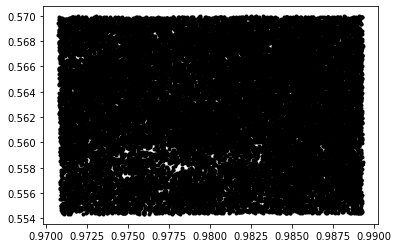

In [38]:
ds_old = df_multi_groupby_inclusive
plt.plot(ds['mean']['RA'], ds['mean']['DEC'], 'k.')

In [39]:
ds_old

mean                                          \
                  MEANMJDOBS        RA       DEC    JMHPNT JMHPNTERR   
SOURCEID                                                               
44989782425636  56996.757397  0.980061  0.557602  1.166593  0.177377   
44989782425657  56995.009049  0.980041  0.556831  0.868558  0.040707   
44989782425659  57002.207504  0.980032  0.556904  1.023378  0.270562   
44989782425662  56975.287272  0.980042  0.555072       NaN       NaN   
44989782425663  56997.313274  0.980042  0.555073  1.138789  0.228608   
...                      ...       ...       ...       ...       ...   
44989782510378  56979.890633  0.975586  0.568335  0.791509  0.128899   
44989782510467  56973.802980  0.973678  0.568999       NaN       NaN   
44989782510480  57002.047216  0.973165  0.569096       NaN       NaN   
44989782510495  56992.114741  0.974004  0.569089  0.607572  0.015512   
44989782510579  56959.488498  0.973811  0.569788       NaN       NaN   

                                                                        ...  \
                  HMKPNT HMKPNTERR  JAPERMAG3  JAPERMAG3ERR  HAPERMAG3  ...   
SOURCEID                                                                ...   
44989782425636  0.582503  0.135496  19.189306  2.647761e+08  18.024357  ...   
44989782425657  0.425294  0.034894  17.215374  2.377581e+07  16.344858  ...   
44989782425659  0.498455  0.263469  19.794195  8.436202e+08  18.818468  ...   
44989782425662  1.285171  0.197845        NaN  1.040192e+09  18.461399  ...   
44989782425663  1.149653  0.168479  19.677401  1.001184e+09  18.550827  ...   
...                  ...       ...        ...           ...        ...  ...   
44989782510378  0.523089  0.129042  18.442432  2.080384e+08  17.715822  ...   
44989782510467  0.843327  0.238310        NaN  1.040192e+09  18.910107  ...   
44989782510480  0.832560  0.212263  19.371468  9.824033e+08  18.603592  ...   
44989782510495  0.318886  0.016430  16.027012  4.200774e+08  15.393021  ...   
44989782510579  0.741639  0.253255        NaN  1.040192e+09  18.973705  ...   

                  count                                                        \
               N_K_good N_J_info N_H_info N_K_info N_J_warn N_H_warn N_K_warn   
SOURCEID                                                                        
44989782425636     84.0      0.0      0.0      0.0     58.0     71.0     69.0   
44989782425657    140.0      0.0      0.0      0.0     19.0     17.0     20.0   
44989782425659     61.0      0.0      0.0      0.0      8.0     41.0     35.0   
44989782425662      7.0      0.0      0.0      0.0      0.0      0.0      3.0   
44989782425663     77.0      0.0      0.0      0.0      0.0     40.0     71.0   
...                 ...      ...      ...      ...      ...      ...      ...   
44989782510378     15.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782510467     10.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782510480      8.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782510495      0.0     31.0     41.0     41.0      0.0      0.0      0.0   
44989782510579      2.0      0.0      0.0      0.0      0.0      0.0      0.0   

                                                 
               N_J_severe N_H_severe N_K_severe  
SOURCEID                                         
44989782425636        1.0        0.0        3.0  
44989782425657        2.0        3.0        3.0  
44989782425659        0.0        2.0        3.0  
44989782425662        0.0        0.0        0.0  
44989782425663        0.0        2.0        8.0  
...                   ...        ...        ...  
44989782510378        1.0        1.0        2.0  
44989782510467        0.0        0.0        0.0  
44989782510480        0.0        0.0        0.0  
44989782510495        0.0        0.0        0.0  
44989782510579        0.0        4.0       13.0  

[27769 rows x 123 columns]

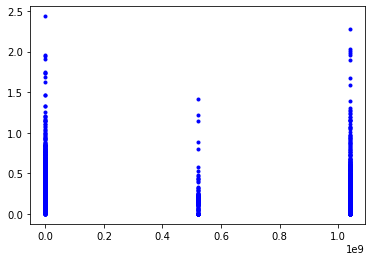

In [40]:
plt.plot(ds_old['median']['JAPERMAG3ERR'], ds_old['std']['JAPERMAG3'], 'b.')
# plt.plot([0,1], [0,1], lw=5, c='k', alpha=0.5, scalex=False, scaley=False)
xmax = ds_old['median']['JAPERMAG3ERR'].max()
# plt.xlim(0, xmax)
# plt.ylim(0, xmax)

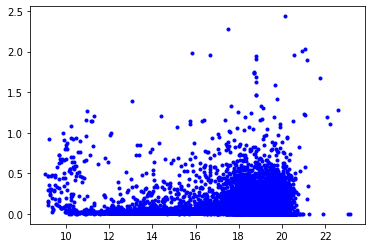

In [41]:
plt.plot(ds_old['median']['JAPERMAG3'], ds_old['std']['JAPERMAG3'], 'b.')

In [42]:
np.percentile(ds_old['median']['JAPERMAG3'], 90)

nan

In [19]:
df

,SOURCEID,MEANMJDOBS,RA,DEC,JMHPNT,JMHPNTERR,HMKPNT,HMKPNTERR,JAPERMAG3,JAPERMAG3ERR,HAPERMAG3,HAPERMAG3ERR,KAPERMAG3,KAPERMAG3ERR,JPPERRBITS,HPPERRBITS,KPPERRBITS,MERGEDCLASS,PSTAR
0,44989782425636,56849.626177,0.980061,0.557602,NaN,NaN,0.832344,0.180055,NaN,1.040192e+09,18.086098,1.250755e-01,17.253754,1.425356e-01,0,32768,32768,1,0.003067
1,44989782425636,56849.629000,0.980061,0.557602,NaN,NaN,1.121714,0.203761,NaN,1.040192e+09,18.063459,1.855512e-01,16.941746,1.066585e-01,0,0,0,1,0.003067
2,44989782425636,56850.617897,0.980062,0.557604,NaN,NaN,NaN,NaN,19.007324,1.791137e-01,NaN,1.040192e+09,NaN,1.040192e+09,0,0,0,-1,0.900000
3,44989782425636,56850.619583,0.980060,0.557602,NaN,NaN,0.812544,0.165643,NaN,1.040192e+09,18.138491,1.243254e-01,17.325947,1.229342e-01,0,0,0,-2,0.486486
4,44989782425636,56853.625150,0.980061,0.557602,NaN,NaN,NaN,NaN,NaN,1.040192e+09,NaN,1.040192e+09,17.275709,1.229759e-01,0,0,0,1,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647984,44989782510579,57006.276060,0.973811,0.569786,NaN,NaN,NaN,NaN,NaN,1.040192e+09,NaN,1.040192e+09,18.122734,1.953976e-01,0,0,0,1,0.050000
1647985,44989782510579,57037.250493,0.973811,0.569788,NaN,NaN,0.918955,0.267231,NaN,1.040192e+09,19.029715,2.080784e-01,18.110760,1.866906e-01,0,524288,524288,1,0.003067
1647986,44989782510579,57043.280120,0.973811,0.569788,NaN,NaN,NaN,NaN,NaN,1.040192e+09,NaN,1.040192e+09,17.989620,1.637523e-01,0,0,524288,1,0.050000
1647987,44989782510579,57049.213857,0.973811,0.569786,NaN,NaN,NaN,NaN,NaN,1.040192e+09,19.071558,2.426583e-01,NaN,1.040192e+09,0,0,0,1,0.050000


In [20]:
df_multi_groupby_inclusive['count']

,N_J,N_H,N_K,N_J_good,N_H_good,N_K_good,N_J_info,N_H_info,N_K_info,N_J_warn,N_H_warn,N_K_warn,N_J_severe,N_H_severe,N_K_severe
SOURCEID,,,,,,,,,,,,,,,
44989782425636,123.0,151.0,156.0,64.0,80.0,84.0,0.0,0.0,0.0,58.0,71.0,69.0,1.0,0.0,3.0
44989782425657,171.0,167.0,163.0,150.0,147.0,140.0,0.0,0.0,0.0,19.0,17.0,20.0,2.0,3.0,3.0
44989782425659,24.0,112.0,99.0,16.0,69.0,61.0,0.0,0.0,0.0,8.0,41.0,35.0,0.0,2.0,3.0
44989782425662,0.0,5.0,10.0,0.0,5.0,7.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
44989782425663,6.0,107.0,156.0,6.0,65.0,77.0,0.0,0.0,0.0,0.0,40.0,71.0,0.0,2.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44989782510378,16.0,14.0,17.0,15.0,13.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
44989782510467,0.0,4.0,10.0,0.0,4.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44989782510480,1.0,11.0,8.0,1.0,11.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


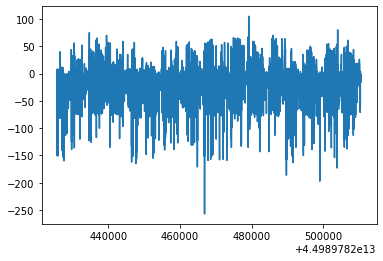

In [21]:
plt.plot(df_multi_groupby_inclusive['count']['N_J'] - df_multi_groupby_inclusive['count']['N_K'])

In [26]:
df_multi_groupby_inclusive.to_hdf("wserv8_multiindexed_summary_3Aug2020.h5", key='table')
# df_multi_groupby_inclusive.to_hdf?

In [29]:
retrieved_table = pd.read_hdf("wserv8_multiindexed_summary_3Aug2020.h5", key='table')

In [32]:
retrieved_table

mean                                          \
                  MEANMJDOBS        RA       DEC    JMHPNT JMHPNTERR   
SOURCEID                                                               
44989782425636  56996.757397  0.980061  0.557602  1.166593  0.177377   
44989782425657  56995.009049  0.980041  0.556831  0.868558  0.040707   
44989782425659  57002.207504  0.980032  0.556904  1.023378  0.270562   
44989782425662  56975.287272  0.980042  0.555072       NaN       NaN   
44989782425663  56997.313274  0.980042  0.555073  1.138789  0.228608   
...                      ...       ...       ...       ...       ...   
44989782510378  56979.890633  0.975586  0.568335  0.791509  0.128899   
44989782510467  56973.802980  0.973678  0.568999       NaN       NaN   
44989782510480  57002.047216  0.973165  0.569096       NaN       NaN   
44989782510495  56992.114741  0.974004  0.569089  0.607572  0.015512   
44989782510579  56959.488498  0.973811  0.569788       NaN       NaN   

                                                                        ...  \
                  HMKPNT HMKPNTERR  JAPERMAG3  JAPERMAG3ERR  HAPERMAG3  ...   
SOURCEID                                                                ...   
44989782425636  0.582503  0.135496  19.189306  2.647761e+08  18.024357  ...   
44989782425657  0.425294  0.034894  17.215374  2.377581e+07  16.344858  ...   
44989782425659  0.498455  0.263469  19.794195  8.436202e+08  18.818468  ...   
44989782425662  1.285171  0.197845        NaN  1.040192e+09  18.461399  ...   
44989782425663  1.149653  0.168479  19.677401  1.001184e+09  18.550827  ...   
...                  ...       ...        ...           ...        ...  ...   
44989782510378  0.523089  0.129042  18.442432  2.080384e+08  17.715822  ...   
44989782510467  0.843327  0.238310        NaN  1.040192e+09  18.910107  ...   
44989782510480  0.832560  0.212263  19.371468  9.824033e+08  18.603592  ...   
44989782510495  0.318886  0.016430  16.027012  4.200774e+08  15.393021  ...   
44989782510579  0.741639  0.253255        NaN  1.040192e+09  18.973705  ...   

                  count                                                        \
               N_K_good N_J_info N_H_info N_K_info N_J_warn N_H_warn N_K_warn   
SOURCEID                                                                        
44989782425636     84.0      0.0      0.0      0.0     58.0     71.0     69.0   
44989782425657    140.0      0.0      0.0      0.0     19.0     17.0     20.0   
44989782425659     61.0      0.0      0.0      0.0      8.0     41.0     35.0   
44989782425662      7.0      0.0      0.0      0.0      0.0      0.0      3.0   
44989782425663     77.0      0.0      0.0      0.0      0.0     40.0     71.0   
...                 ...      ...      ...      ...      ...      ...      ...   
44989782510378     15.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782510467     10.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782510480      8.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782510495      0.0     31.0     41.0     41.0      0.0      0.0      0.0   
44989782510579      2.0      0.0      0.0      0.0      0.0      0.0      0.0   

                                                 
               N_J_severe N_H_severe N_K_severe  
SOURCEID                                         
44989782425636        1.0        0.0        3.0  
44989782425657        2.0        3.0        3.0  
44989782425659        0.0        2.0        3.0  
44989782425662        0.0        0.0        0.0  
44989782425663        0.0        2.0        8.0  
...                   ...        ...        ...  
44989782510378        1.0        1.0        2.0  
44989782510467        0.0        0.0        0.0  
44989782510480        0.0        0.0        0.0  
44989782510495        0.0        0.0        0.0  
44989782510579        0.0        4.0       13.0  

[27769 rows x 123 columns]

In [33]:
df

,SOURCEID,MEANMJDOBS,RA,DEC,JMHPNT,JMHPNTERR,HMKPNT,HMKPNTERR,JAPERMAG3,JAPERMAG3ERR,HAPERMAG3,HAPERMAG3ERR,KAPERMAG3,KAPERMAG3ERR,JPPERRBITS,HPPERRBITS,KPPERRBITS,MERGEDCLASS,PSTAR
0,44989782425636,56849.626177,0.980061,0.557602,NaN,NaN,0.832344,0.180055,NaN,1.040192e+09,18.086098,1.250755e-01,17.253754,1.425356e-01,0,32768,32768,1,0.003067
1,44989782425636,56849.629000,0.980061,0.557602,NaN,NaN,1.121714,0.203761,NaN,1.040192e+09,18.063459,1.855512e-01,16.941746,1.066585e-01,0,0,0,1,0.003067
2,44989782425636,56850.617897,0.980062,0.557604,NaN,NaN,NaN,NaN,19.007324,1.791137e-01,NaN,1.040192e+09,NaN,1.040192e+09,0,0,0,-1,0.900000
3,44989782425636,56850.619583,0.980060,0.557602,NaN,NaN,0.812544,0.165643,NaN,1.040192e+09,18.138491,1.243254e-01,17.325947,1.229342e-01,0,0,0,-2,0.486486
4,44989782425636,56853.625150,0.980061,0.557602,NaN,NaN,NaN,NaN,NaN,1.040192e+09,NaN,1.040192e+09,17.275709,1.229759e-01,0,0,0,1,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647984,44989782510579,57006.276060,0.973811,0.569786,NaN,NaN,NaN,NaN,NaN,1.040192e+09,NaN,1.040192e+09,18.122734,1.953976e-01,0,0,0,1,0.050000
1647985,44989782510579,57037.250493,0.973811,0.569788,NaN,NaN,0.918955,0.267231,NaN,1.040192e+09,19.029715,2.080784e-01,18.110760,1.866906e-01,0,524288,524288,1,0.003067
1647986,44989782510579,57043.280120,0.973811,0.569788,NaN,NaN,NaN,NaN,NaN,1.040192e+09,NaN,1.040192e+09,17.989620,1.637523e-01,0,0,524288,1,0.050000
1647987,44989782510579,57049.213857,0.973811,0.569786,NaN,NaN,NaN,NaN,NaN,1.040192e+09,19.071558,2.426583e-01,NaN,1.040192e+09,0,0,0,1,0.050000


In [34]:
%run ../variability_selection


In [35]:
import time
start = time.time()
ds_new = spreadsheet_maker(df)
end = time.time()
elapsed_time = end - start
print(f"Elapsed time: {elapsed_time:.1f} s")

/Users/tsrice/Documents/Variability_Project_2020/wuvars/analysis/variability_selection.py:223: RuntimeWarning: Mean of empty slice
  d.append(fn(x[column]))
/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/tsrice/Documents/Variability_Project_2020/wuvars/analysis/variability_selection.py:223: RuntimeWarning: All-NaN axis encountered
  d.append(fn(x[column]))
/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/tsrice/Documents/Variability_Project_2020/wuvars/analysis/variability_selection.py:184: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) - np.nanmin(x),
/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=

Elapsed time: 1074.6 s


In [36]:
ds_new

mean                                          \
                  MEANMJDOBS        RA       DEC    JMHPNT JMHPNTERR   
SOURCEID                                                               
44989782425636  56996.757397  0.980061  0.557602  1.166593  0.177377   
44989782425657  56995.009049  0.980041  0.556831  0.868558  0.040707   
44989782425659  57002.207504  0.980032  0.556904  1.023378  0.270562   
44989782425662  56975.287272  0.980042  0.555072       NaN       NaN   
44989782425663  56997.313274  0.980042  0.555073  1.138789  0.228608   
...                      ...       ...       ...       ...       ...   
44989782510378  56979.890633  0.975586  0.568335  0.791509  0.128899   
44989782510467  56973.802980  0.973678  0.568999       NaN       NaN   
44989782510480  57002.047216  0.973165  0.569096       NaN       NaN   
44989782510495  56992.114741  0.974004  0.569089  0.607572  0.015512   
44989782510579  56959.488498  0.973811  0.569788       NaN       NaN   

                                                                        ...  \
                  HMKPNT HMKPNTERR  JAPERMAG3  JAPERMAG3ERR  HAPERMAG3  ...   
SOURCEID                                                                ...   
44989782425636  0.582503  0.135496  19.189306  2.647761e+08  18.024357  ...   
44989782425657  0.425294  0.034894  17.215374  2.377581e+07  16.344858  ...   
44989782425659  0.498455  0.263469  19.794195  8.436202e+08  18.818468  ...   
44989782425662  1.285171  0.197845        NaN  1.040192e+09  18.461399  ...   
44989782425663  1.149653  0.168479  19.677401  1.001184e+09  18.550827  ...   
...                  ...       ...        ...           ...        ...  ...   
44989782510378  0.523089  0.129042  18.442432  2.080384e+08  17.715822  ...   
44989782510467  0.843327  0.238310        NaN  1.040192e+09  18.910107  ...   
44989782510480  0.832560  0.212263  19.371468  9.824033e+08  18.603592  ...   
44989782510495  0.318886  0.016430  16.027012  4.200774e+08  15.393021  ...   
44989782510579  0.741639  0.253255        NaN  1.040192e+09  18.973705  ...   

                    count                       variability              \
               N_J_severe N_H_severe N_K_severe J_red_chisq H_red_chisq   
SOURCEID                                                                  
44989782425636        1.0        0.0        3.0    0.869839    1.179282   
44989782425657        2.0        3.0        3.0    0.787800    0.637044   
44989782425659        0.0        2.0        3.0    1.161457    0.919597   
44989782425662        0.0        0.0        0.0   -0.000000    1.266427   
44989782425663        0.0        2.0        8.0    1.375828    1.073700   
...                   ...        ...        ...         ...         ...   
44989782510378        1.0        1.0        2.0    0.926094    3.107611   
44989782510467        0.0        0.0        0.0   -0.000000    0.933145   
44989782510480        0.0        0.0        0.0         NaN    0.941708   
44989782510495        0.0        0.0        0.0   17.971535   18.360905   
44989782510579        0.0        4.0       13.0   -0.000000    0.220586   

                                                                          
                K_red_chisq Stetson_HK Stetson_JK Stetson_JH JHK_Stetson  
SOURCEID                                                                  
44989782425636     1.443569   0.028704  -0.007470   0.021534    0.051379  
44989782425657     0.736154  -0.024033   0.028455   0.073043    0.079970  
44989782425659     0.883313   0.007132   0.108433  -0.278443   -0.168218  
44989782425662     5.757782   1.064455        NaN        NaN         NaN  
44989782425663     1.321437   0.012618   0.019132   0.122483    0.377737  
...                     ...        ...        ...        ...         ...  
44989782510378  1161.530029  -0.068907  -0.020359   0.033436   -0.079445  
44989782510467     0.540409  -0.623504        NaN        NaN         NaN  
44989782510480     1.027860   0.

In [67]:
ds = ds_new

v = 'variability'
mean = 'mean'
median = 'median'

S_JHK = "JHK_Stetson"
S_JH = "Stetson_JH"
S_JK = "Stetson_JK"
S_HK = "Stetson_HK"

q2_all_indices = (
    (ds["count"]["N_J"] > 50)
    & (ds["count"]["N_J"] < 150)
    & (ds["count"]["N_H"] > 50)
    & (ds["count"]["N_H"] < 150)
    & (ds["count"]["N_K"] > 50)
    & (ds["count"]["N_K"] < 150)
    & (ds["max"]["JPPERRBITS"] == 0)
    & (ds["max"]["HPPERRBITS"] == 0)
    & (ds["max"]["KPPERRBITS"] == 0)
    & (ds["median"]["PSTAR"] > 0.75)
)

variable_indices = q2_all_indices & (
    (ds[v][S_JHK] > 2)
    | (ds[v][S_JH] > 2)
    | (ds[v][S_HK] > 2)
    | (ds[v][S_JK] > 2)
    | (ds[v]["J_red_chisq"] > 2)
    | (ds[v]["H_red_chisq"] > 2)
    | (ds[v]["K_red_chisq"] > 2)
)


In [68]:
np.sum(q2_all_indices)

7239

In [69]:
np.sum(variable_indices)

213